# Cyberattack Classification Using Deep Learning

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

c:\Program Files\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Table of Contents

1. **Introduction**  
2. **Dataset Description**  
3. **Problem Statement**  
4. **Data Preprocessing**  
   - Handling Outliers  
   - Encoding Categorical Features  
   - Standardization  
   - Feature Selection  
5. **Model Architecture**  
6. **Training and Evaluation**  
7. **Results**  
8. **Conclusions**  
9. **References**


## 1. Introduction

Cybersecurity is a critical area in today's connected world. Identifying and classifying cyberattacks using deep learning can provide a robust solution to mitigate threats efficiently. This project focuses on using the **UNSW-NB15** dataset to build a deep learning model for multi-class classification of cyberattacks.

---

## 2. Dataset Description

The UNSW-NB15 dataset contains a diverse range of network attack data. It includes normal and nine types of attack categories:
- Fuzzers
- Analysis
- Backdoors
- DoS
- Exploits
- Generic
- Reconnaissance
- Shellcode
- Worms

Each instance includes 49 features and labels for attack categories.
- - -

In [2]:
class NetworkTrafficPipeline:
    def __init__(self):
        self.preprocessor = None
        self.model = None
        self.path = None
        
    def download_dataset(self):
        """Download dataset using kagglehub."""
        self.path = kagglehub.dataset_download("dhoogla/unswnb15")
        print("Dataset downloaded to:", self.path)
        return self.path
    
    def load_data(self):
        """Load training and testing datasets."""
        train_data = pd.read_parquet(f"{self.path}/UNSW_NB15_training-set.parquet")
        test_data = pd.read_parquet(f"{self.path}/UNSW_NB15_testing-set.parquet")
        return train_data, test_data

In [3]:
# Initialize pipeline
pipeline = NetworkTrafficPipeline()
    
# Download and load data
path = pipeline.download_dataset()
train_data, test_data = pipeline.load_data()

Dataset downloaded to: C:\Users\Administrator\.cache\kagglehub\datasets\dhoogla\unswnb15\versions\5


# 3. Problem Statement 

This project focuses on network intrusion detection using deep learning techniques. Our main objectives are:

- Develop a robust multi-class classification model for network traffic
- Address the class imbalance challenge in cybersecurity datasets
- Create an effective preprocessing pipeline for network traffic data
- Implement and evaluate a deep learning solution for real-time threat detection
- - -



# 4 Data Analysis

In [4]:
class DataAnalyzer:
    """
    A comprehensive class for exploratory data analysis and feature engineering insights.
    
    This class provides methods for:
    - Basic statistical analysis
    - Correlation detection
    - Outlier identification
    - Feature engineering suggestions and visualization
    - Data distribution analysis
    """
    
    def __init__(self, df):
        """
        Initialize the analyzer with a pandas DataFrame.
        
        Args:
            df (pd.DataFrame): Input dataset for analysis
        """
        self.df = df.copy()  # Create a copy to avoid modifying original data
        self.num_cols = self.df.select_dtypes(include=['int64', 'float64']).columns
        self.cat_cols = self.df.select_dtypes(include=['object', 'category', 'bool']).columns
        
    def basic_analysis(self):
        """
        Perform basic dataset analysis.
        
        Returns:
            dict: Contains missing values, numerical statistics, and categorical counts
        """
        analysis = {
            'missing_values': {
                'count': self.df.isnull().sum(),
                'percentage': (self.df.isnull().sum() / len(self.df) * 100).round(2)
            },
            'numerical_stats': self.df[self.num_cols].describe(),
            'categorical_stats': {
                col: {
                    'unique_values': self.df[col].nunique(),
                    'value_counts': self.df[col].value_counts(),
                    'missing_percentage': (self.df[col].isnull().sum() / len(self.df) * 100).round(2)
                } for col in self.cat_cols
            }
        }
        return analysis
    
    def identify_correlations(self, threshold=0.7):
        """
        Identify strong correlations between numerical features.
        
        Args:
            threshold (float): Correlation coefficient threshold (default: 0.7)
            
        Returns:
            pd.DataFrame: Pairs of highly correlated features
        """
        if len(self.num_cols) < 2:
            return pd.DataFrame()
            
        corr_matrix = self.df[self.num_cols].corr()
        high_corr = np.where(np.abs(corr_matrix) > threshold)
        high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                          for x, y in zip(*high_corr) if x != y and x < y]
        return pd.DataFrame(high_corr_pairs, columns=['Feature1', 'Feature2', 'Correlation'])
    
    def detect_outliers(self, cols=None, method='zscore', threshold=3):
        """
        Detect outliers using multiple methods.
        
        Args:
            cols (list): Specific columns to check (default: all numerical columns)
            method (str): 'zscore' or 'iqr' (default: 'zscore')
            threshold (float): Threshold for outlier detection (default: 3)
            
        Returns:
            dict: Outlier statistics for each analyzed column
        """
        if cols is None:
            cols = self.num_cols
            
        outliers = {}
        for col in cols:
            if method == 'zscore':
                z_scores = np.abs(stats.zscore(self.df[col].dropna()))
                outlier_mask = z_scores > threshold
            else:  # IQR method
                Q1 = self.df[col].quantile(0.25)
                Q3 = self.df[col].quantile(0.75)
                IQR = Q3 - Q1
                outlier_mask = ((self.df[col] < (Q1 - 1.5 * IQR)) | 
                              (self.df[col] > (Q3 + 1.5 * IQR)))
                
            outliers[col] = {
                'count': outlier_mask.sum(),
                'percentage': (outlier_mask.sum() / len(self.df[col].dropna()) * 100).round(2),
                'indexes': self.df[outlier_mask].index.tolist(),
                'range': {
                    'min': self.df[col][~outlier_mask].min(),
                    'max': self.df[col][~outlier_mask].max()
                }
            }
        return outliers
    
    def analyze_class_distribution(self, data, plot=True):
        """
        Analyze the distribution of classes in a dataset.
        
        Args:
            data (pd.DataFrame): Dataset 
            plot (bool): If True, display a bar plot of class distribution (default: True)
            
        Returns:
            pd.Series: Contagem de cada classe
        """
        class_distribution = data['attack_cat'].value_counts()
        
        if plot:
            plt.figure(figsize=(12, 6))
            sns.barplot(x=class_distribution.index, y=class_distribution.values)
            plt.xticks(rotation=45)
            plt.title('Attack Category Distribution')
            plt.xlabel('Attack Category')
            plt.ylabel('Count')
            plt.tight_layout()
            plt.show()
            
            # Gráfico de pizza para proporção normal vs. ataque
            plt.figure(figsize=(8, 8))
            attack_prop = data['label'].value_counts()
            plt.pie(attack_prop, labels=['Normal', 'Attack'], autopct='%1.1f%%')
            plt.title('Normal vs. Attack Traffic Distribution')
            plt.show()
        
        return class_distribution

## 4.1 Dataset Overview
The dataset contains network traffic information with both normal and malicious activities. Key characteristics include:

- Multiple features capturing network behavior
- 10 distinct classes (Normal + 9 attack categories)
- Significant class imbalance (Normal traffic dominates)
- Mix of numerical and categorical features


In [5]:
print(train_data.head())

        dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0  0.121478   tcp       -   FIN      6      4     258     172  74.087486   
1  0.649902   tcp       -   FIN     14     38     734   42014  78.473373   
2  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4  0.449454   tcp       -   FIN     10      6     534     268  33.373825   

          sload  ...  trans_depth  response_body_len  ct_src_dport_ltm  \
0  14158.942383  ...            0                  0                 1   
1   8395.112305  ...            0                  0                 1   
2   1572.271851  ...            0                  0                 1   
3   2740.178955  ...            0                  0                 1   
4   8561.499023  ...            0                  0                 2   

   ct_dst_sport_ltm  is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  \
0                 1            

In [6]:
DataAnalyzer(train_data).basic_analysis()

{'missing_values': {'count': dur                  0
  proto                0
  service              0
  state                0
  spkts                0
  dpkts                0
  sbytes               0
  dbytes               0
  rate                 0
  sload                0
  dload                0
  sloss                0
  dloss                0
  sinpkt               0
  dinpkt               0
  sjit                 0
  djit                 0
  swin                 0
  stcpb                0
  dtcpb                0
  dwin                 0
  tcprtt               0
  synack               0
  ackdat               0
  smean                0
  dmean                0
  trans_depth          0
  response_body_len    0
  ct_src_dport_ltm     0
  ct_dst_sport_ltm     0
  is_ftp_login         0
  ct_ftp_cmd           0
  ct_flw_http_mthd     0
  is_sm_ips_ports      0
  attack_cat           0
  label                0
  dtype: int64,
  'percentage': dur                  0.0
  proto         

In [7]:
DataAnalyzer(train_data).detect_outliers()

{'stcpb': {'count': 0,
  'percentage': 0.0,
  'indexes': [],
  'range': {'min': 0, 'max': 4294958913}},
 'dtcpb': {'count': 0,
  'percentage': 0.0,
  'indexes': [],
  'range': {'min': 0, 'max': 4294881924}}}

## 4.2 Class Distribution
Analysis of attack categories shows:
- Normal traffic: ~90,000 instances
- Generic attacks: ~58,000 instances
- Exploits: ~44,000 instances
- Fuzzers: ~24,000 instances
- DoS: ~16,000 instances
- Reconnaissance: ~13,000 instances
- Analysis: ~2,000 instances
- Backdoor: ~2,000 instances
- Shellcode: ~1,500 instances
- Worms: ~130 instances

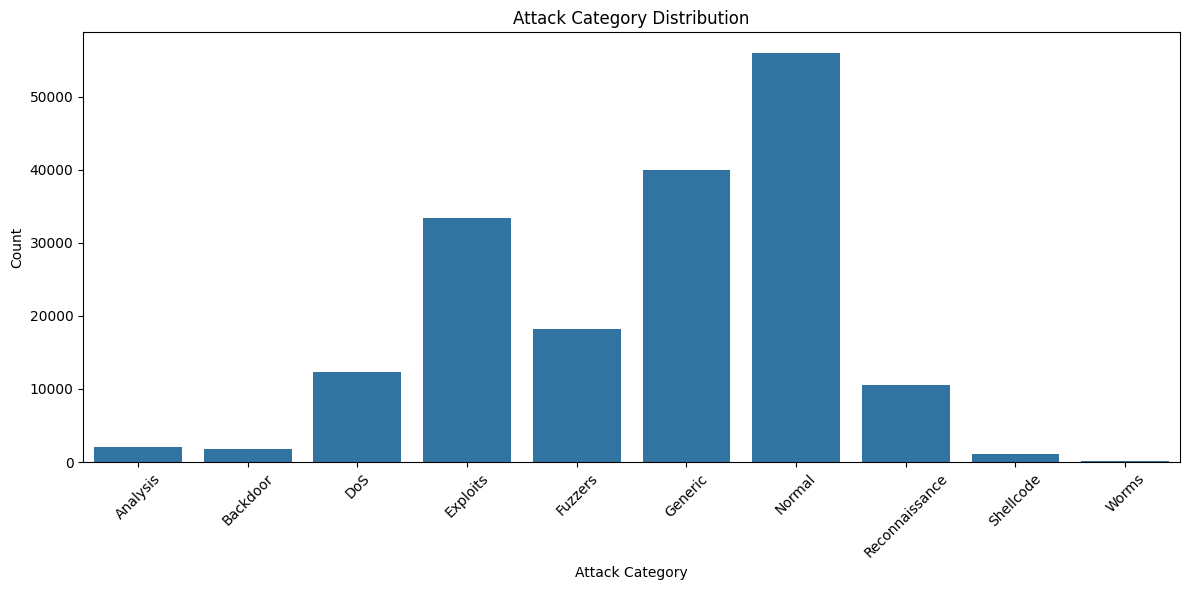

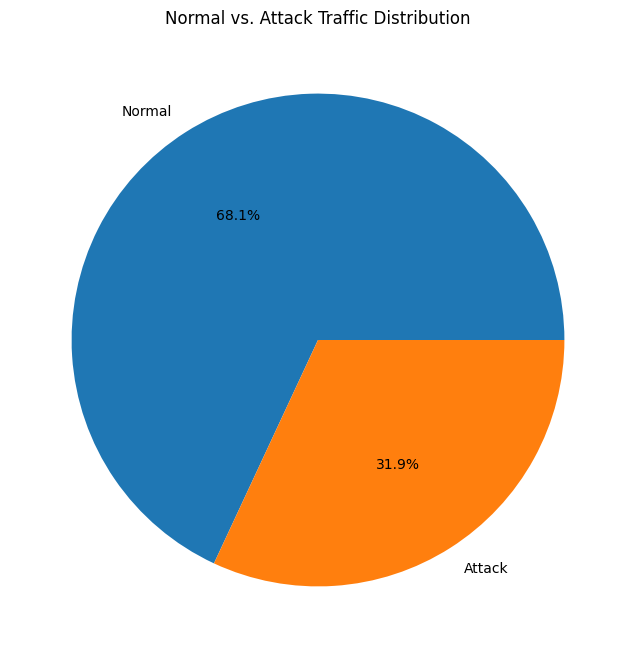

attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64

In [8]:
DataAnalyzer(train_data).analyze_class_distribution(train_data)

## 4.3 Feature Analysis
The dataset includes various types of features:
- Network flow metrics (duration, packet counts)
- Protocol information
- Service types
- Connection states
- Binary indicators

# 5. Data Preprocessing


The `Preprocessor` class handles data preprocessing, aiming to prepare both training and test datasets for machine learning models, particularly for multi-class cyber attack classification tasks. Below are the key steps executed:

### 5.1. **Loading and Initial Setup**
   - The class is initialized with training and test data.
   - Scalers and label encoders are set up.
   - Categorical columns and other parameters like feature selection are defined.

### 5.2. **Feature Engineering**
   - New features are created to better capture patterns in the data:
     - **Packet-based features**: Relationships between bytes and packets.
     - **Time-based features**: Rate of bytes and packets per second.
     - **Rate-based features**: Rate of sent and received packets.
     - **Statistical features**: Relationships between bytes and packets.
     - **Interaction features**: Load calculations (sload and dload) based on bytes and rates.

### 5.3. **Outlier Handling**
   - Outliers in the data are addressed using the **Interquartile Range (IQR)** method.
   - The clip function limits extreme values to within bounds determined by the quartiles, reducing the impact of outliers that could affect model training.

### 5.4. **Feature Selection**
   - The most relevant features are selected based on **mutual information** between independent variables and the target variable.
   - The top `n_features` are chosen to reduce dimensionality and improve model performance.

### 5.5. **Class Balancing**
   - Advanced class balancing techniques are used to address class imbalance:
     - **Tomek Links**: Removes noisy or ambiguous examples near the decision boundary between majority and minority classes.
     - **ADASYN**: Over-samples minority classes representing less than 10% of the dataset, helping to balance class distribution.

### 5.6. **Training Set Preprocessing**
   - Unnecessary columns are dropped.
   - Engineered features are added.
   - Categorical columns are encoded using `LabelEncoder`.
   - The dataset is split into features (`X`) and target (`y`).
   - Outliers are handled in numeric columns.
   - Feature selection is applied.
   - Features are scaled using **RobustScaler**, which is more robust to outliers.

### 5.7. **Test Set Preprocessing**
   - The test set undergoes similar preprocessing as the training set, with special attention to handling unknown categories in categorical columns according to the training set classes.
   - Selected features and scaling are applied to ensure consistency with the training data.

---

In [9]:
class DataAnalyzer:
    """
    A comprehensive class for exploratory data analysis and feature engineering insights.
    
    This class provides methods for:
    - Basic statistical analysis
    - Correlation detection
    - Outlier identification
    - Feature engineering suggestions and visualization
    - Data distribution analysis
    """
    
    def __init__(self, df):
        """
        Initialize the analyzer with a pandas DataFrame.
        
        Args:
            df (pd.DataFrame): Input dataset for analysis
        """
        self.df = df.copy()  # Create a copy to avoid modifying original data
        self.num_cols = self.df.select_dtypes(include=['int64', 'float64']).columns
        self.cat_cols = self.df.select_dtypes(include=['object', 'category', 'bool']).columns

    def basic_analysis(self):
        """
        Perform basic dataset analysis.
        
        Returns:
            dict: Contains missing values, numerical statistics, and categorical counts
        """
        analysis = {
            'missing_values': {
                'count': self.df.isnull().sum(),
                'percentage': (self.df.isnull().sum() / len(self.df) * 100).round(2)
            },
            'numerical_stats': self.df[self.num_cols].describe(),
            'categorical_stats': {
                col: {
                    'unique_values': self.df[col].nunique(),
                    'value_counts': self.df[col].value_counts(),
                    'missing_percentage': (self.df[col].isnull().sum() / len(self.df) * 100).round(2)
                } for col in self.cat_cols
            }
        }
        return analysis

    def identify_correlations(self, threshold=0.7):
        """
        Identify strong correlations between numerical features.
        
        Args:
            threshold (float): Correlation coefficient threshold (default: 0.7)
            
        Returns:
            pd.DataFrame: Pairs of highly correlated features
        """
        if len(self.num_cols) < 2:
            return pd.DataFrame()
            
        corr_matrix = self.df[self.num_cols].corr()
        high_corr = np.where(np.abs(corr_matrix) > threshold)
        high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                          for x, y in zip(*high_corr) if x != y and x < y]
        return pd.DataFrame(high_corr_pairs, columns=['Feature1', 'Feature2', 'Correlation'])

    def detect_outliers(self, cols=None, method='zscore', threshold=3):
        """
        Detect outliers using multiple methods.
        
        Args:
            cols (list): Specific columns to check (default: all numerical columns)
            method (str): 'zscore' or 'iqr' (default: 'zscore')
            threshold (float): Threshold for outlier detection (default: 3)
            
        Returns:
            dict: Outlier statistics for each analyzed column
        """
        if cols is None:
            cols = self.num_cols
            
        outliers = {}
        for col in cols:
            if method == 'zscore':
                z_scores = np.abs(stats.zscore(self.df[col].dropna()))
                outlier_mask = z_scores > threshold
            else:  # IQR method
                Q1 = self.df[col].quantile(0.25)
                Q3 = self.df[col].quantile(0.75)
                IQR = Q3 - Q1
                outlier_mask = ((self.df[col] < (Q1 - 1.5 * IQR)) | 
                              (self.df[col] > (Q3 + 1.5 * IQR)))
                
            outliers[col] = {
                'count': outlier_mask.sum(),
                'percentage': (outlier_mask.sum() / len(self.df[col].dropna()) * 100).round(2),
                'indexes': self.df[outlier_mask].index.tolist(),
                'range': {
                    'min': self.df[col][~outlier_mask].min(),
                    'max': self.df[col][~outlier_mask].max()
                }
            }
        return outliers

    def analyze_class_distribution(self, data, plot=True):
        """
        Analyze the distribution of classes in a dataset.
        
        Args:
            data (pd.DataFrame): Dataset 
            plot (bool): If True, display a bar plot of class distribution (default: True)
            
        Returns:
            pd.Series: Contagem de cada classe
        """
        class_distribution = data['attack_cat'].value_counts()
        
        if plot:
            plt.figure(figsize=(12, 6))
            sns.barplot(x=class_distribution.index, y=class_distribution.values)
            plt.xticks(rotation=45)
            plt.title('Attack Category Distribution')
            plt.xlabel('Attack Category')
            plt.ylabel('Count')
            plt.tight_layout()
            plt.show()
            
            # Gráfico de pizza para proporção normal vs. ataque
            plt.figure(figsize=(8, 8))
            attack_prop = data['label'].value_counts()
            plt.pie(attack_prop, labels=['Normal', 'Attack'], autopct='%1.1f%%')
            plt.title('Normal vs. Attack Traffic Distribution')
            plt.show()
        
        return class_distribution


class Preprocessor:
    def __init__(self, train_data, test_data):
        self.train_data = train_data.copy()
        self.test_data = test_data.copy()
        self.scalers = {
            'standard': StandardScaler(),
            'robust': RobustScaler()
        }
        self.label_encoder = {}
        self.categorical_columns = ['proto', 'service', 'state']
        self.selected_features = None
        self.feature_selector = None

    def add_engineered_features(self, data):
        """Add engineered features to improve model performance."""
        # Packet-based features
        data['bytes_per_packet'] = data['sbytes'] / (data['spkts'] + 1e-8)
        data['packet_size_ratio'] = (data['sbytes'] + 1e-8) / (data['dbytes'] + 1e-8)
        
        # Time-based features
        data['bytes_per_second'] = (data['sbytes'] + data['dbytes']) / (data['dur'] + 1e-8)
        data['packets_per_second'] = (data['spkts'] + data['dpkts']) / (data['dur'] + 1e-8)
        
        # Rate-based features
        data['srate'] = data['spkts'] / (data['dur'] + 1e-8)
        data['drate'] = data['dpkts'] / (data['dur'] + 1e-8)
        
        # Statistical features
        data['byte_ratio'] = np.log1p(data['sbytes']) - np.log1p(data['dbytes'])
        data['packet_ratio'] = np.log1p(data['spkts']) - np.log1p(data['dpkts'])
        
        # Interaction features
        data['sload'] = (data['sbytes'] * data['srate']) / (1e-8 + data['dur'])
        data['dload'] = (data['dbytes'] * data['drate']) / (1e-8 + data['dur'])
        
        return data

    def handle_outliers(self, data, columns, method='iqr'):
        """Handle outliers using IQR method."""
        for column in columns:
            Q1 = data[column].quantile(0.25)
            Q3 = data[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            data[column] = data[column].clip(lower_bound, upper_bound)
        return data

    def select_features(self, X, y, n_features=24):
        """Select most important features using mutual information."""
        if self.feature_selector is None:
            self.feature_selector = SelectKBest(score_func=mutual_info_classif, k=n_features)
            self.feature_selector.fit(X, y)
            self.selected_features = X.columns[self.feature_selector.get_support()].tolist()
        return X[self.selected_features]

    def balance_classes(self, X, y):
        """Advanced class balancing using combination of techniques."""
        # Remove noise using Tomek links
        tl = TomekLinks(sampling_strategy='majority')
        X_cleaned, y_cleaned = tl.fit_resample(X, y)
        
        # Apply ADASYN for minority classes
        minority_classes = [cls for cls, count in pd.Series(y_cleaned).value_counts().items() 
                          if count < len(y_cleaned) * 0.1]
        
        if minority_classes:
            sampling_strategy = {cls: int(len(y_cleaned) * 0.1) for cls in minority_classes}
            adasyn = ADASYN(sampling_strategy=sampling_strategy, random_state=42)
            X_balanced, y_balanced = adasyn.fit_resample(X_cleaned, y_cleaned)
        else:
            X_balanced, y_balanced = X_cleaned, y_cleaned
        
        return X_balanced, y_balanced

    def train_set_preprocess(self):
        """Preprocess training data."""
        # Remove unnecessary columns
        columns_to_drop = ['swin', 'stcpb', 'dtcpb', 'dwin', 'is_sm_ips_ports', 'ct_flw_http_mthd']
        self.train_data.drop(columns=columns_to_drop, errors='ignore', inplace=True)
        
        # Add engineered features
        self.train_data = self.add_engineered_features(self.train_data)
        
        # Handle categorical features
        for col in self.categorical_columns:
            self.label_encoder[col] = LabelEncoder()
            self.train_data[col] = self.label_encoder[col].fit_transform(self.train_data[col])
        
        # Separate features and target
        X = self.train_data.drop(['attack_cat', 'label'], axis=1)
        y = self.train_data['attack_cat']
        
        # Handle numerical features
        numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
        X = self.handle_outliers(X, numerical_columns)
        
        # Encode target
        self.label_encoder['attack_cat'] = LabelEncoder()
        y = self.label_encoder['attack_cat'].fit_transform(y)
        
        # Feature selection
        X = self.select_features(X, y)
        
        # Scale features
        X = pd.DataFrame(self.scalers['robust'].fit_transform(X), columns=X.columns)
        
        return X, y

    def test_set_preprocess(self):
        """Preprocess test data."""
        self.test_data.drop(columns=['swin', 'stcpb', 'dtcpb', 'dwin', 'is_sm_ips_ports', 'ct_flw_http_mthd'], 
                           errors='ignore', inplace=True)
        
        self.test_data = self.add_engineered_features(self.test_data)
        
        for col in self.categorical_columns:
            known_classes = set(self.label_encoder[col].classes_)
            self.test_data[col] = self.test_data[col].map(lambda x: x if x in known_classes else list(known_classes)[0])
            self.test_data[col] = self.label_encoder[col].transform(self.test_data[col])
        
        X = self.test_data.drop(['attack_cat', 'label'], axis=1)
        y = self.test_data['attack_cat']
        
        numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
        X = self.handle_outliers(X, numerical_columns)
        
        known_classes = set(self.label_encoder['attack_cat'].classes_)
        y = y.map(lambda x: x if x in known_classes else list(known_classes)[0])
        y = self.label_encoder['attack_cat'].transform(y)
        
        X = X[self.selected_features]
        X = pd.DataFrame(self.scalers['robust'].transform(X), columns=X.columns)
        
        return X, y


In [10]:
# Initialize preprocessor
preprocessor = Preprocessor(train_data, test_data)
    
# Preprocess training and test data
print("Preprocessing training data...")
X_train, y_train = preprocessor.train_set_preprocess()
    
print("Preprocessing test data...")
X_test, y_test = preprocessor.test_set_preprocess()

Preprocessing training data...
Preprocessing test data...


# 6. Model Architecture


The `OptimizedGRUModel` class defines a GRU-based deep learning model for multi-class classification tasks. The model architecture and hyperparameters were optimized beforehand using **AutoML** techniques, specifically **Keras Tuner** and **Optuna**. The current code implements the model with the best hyperparameters found through this optimization process. Below is a breakdown of the model creation and the steps taken:

### 6.1. **AutoML Optimization (Prior to Model Definition)**
   - **Keras Tuner** and **Optuna** were used to automatically search for optimal hyperparameters for the GRU model. 
   - The goal was to determine the best configuration for layers, units, dropout rates, learning rates, and regularization techniques, optimizing the model's performance on the given task.
   
### 6.2. **Model Architecture**

   - **Input Layer**: 
     - The model starts with a **BatchNormalization** layer to stabilize learning.
     - The input shape is `(sequence_length, input_shape)`, where the sequence length is configurable.
   
   - **First GRU Layer**:
     - A **GRU** layer with 224 units is used to capture temporal dependencies in the data.
     - **L1 and L2** regularization penalties are applied to prevent overfitting (`l1=3.9977e-06` and `l2=1.1334e-05`).
     - The layer is **bidirectional**, meaning it processes the sequence both forwards and backwards to capture more comprehensive patterns.
   
   - **Second GRU Layer**:
     - A second **GRU** layer with 128 units is also bidirectional.
     - It includes **L1 and L2** regularization (`l1=0.0000142`, `l2=2.4187e-06`) to further prevent overfitting.
     - **Dropout** is applied with a rate of 0.5 to avoid overfitting in this layer.
   
   - **Dense Layers**:
     - A **Dense** layer with 128 units and **ReLU** activation introduces non-linearity to the model.
     - **BatchNormalization** and **Dropout** (rate of 0.1) are included to help improve training stability and generalization.
   
   - **Output Layer**:
     - The output layer has `num_classes` units, corresponding to the number of categories in the target variable, with **softmax** activation to predict class probabilities.

### 6.3. **Model Compilation**
   - The model is compiled with the **Adam** optimizer, using a learning rate of 0.0003884. This learning rate was selected through AutoML optimization.
   - The **loss function** is **sparse categorical crossentropy**, appropriate for multi-class classification problems.
   - The model is optimized for **accuracy**, which is tracked during training.

### 6.4. **Data Preparation**
   - The `prepare_sequence_data` method is used to convert raw data into sequences of a fixed length (`sequence_length`).
   - The data is padded to ensure the sequences are of equal length, and sliding windows are created to generate sequence input.

### 6.5. **Training Process**
   - The model is trained using the `train` method, which accepts training and validation data, batch size, and epochs as parameters.
   - **Callbacks** used during training:
     - **EarlyStopping** monitors validation loss and stops training if it doesn’t improve for 15 epochs, restoring the best weights.
     - **ModelCheckpoint** saves the best model during training based on validation loss.
     - **ReduceLROnPlateau** reduces the learning rate by a factor of 0.5 if the validation loss doesn’t improve for 7 epochs.

### 6.6. **Evaluation and Prediction**
   - The `evaluate` method assesses the model's performance on the test dataset.
   - The `predict` method generates class predictions for new data, outputting the class with the highest predicted probability.


In [11]:
class OptimizedGRUModel:
    def __init__(self, input_shape, num_classes, sequence_length=10):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.sequence_length = sequence_length
        self.model = self.create_model()
        
    def create_model(self):
        """Create model with optimized hyperparameters."""
        model = Sequential()
        
        # Input layer with BatchNormalization
        model.add(BatchNormalization(input_shape=(self.sequence_length, self.input_shape)))
        
        # First GRU layer - optimized parameters
        gru_layer = GRU(224,  # gru_units_1 = 224
                       return_sequences=True,
                       kernel_regularizer=l1_l2(
                           l1=3.9977e-06,  # l1_1
                           l2=1.1334e-05))  # l2_1
        
        # bidirectional = True
        gru_layer = Bidirectional(gru_layer)
            
        model.add(gru_layer)
        model.add(BatchNormalization())
        model.add(Dropout(0.2))  # dropout_1 = 0.2
        
        # Second GRU layer - optimized parameters
        gru_layer_2 = GRU(128,  # gru_units_2 = 128
                         kernel_regularizer=l1_l2(
                             l1=0.0000142,  # l1_2
                             l2=2.4187e-06))  # l2_2
        
        gru_layer_2 = Bidirectional(gru_layer_2)
            
        model.add(gru_layer_2)
        model.add(BatchNormalization())
        model.add(Dropout(0.5))  # dropout_2 = 0.5
        
        # Dense layers - optimized parameters
        model.add(Dense(128, activation='relu'))  # dense_units = 128
        model.add(BatchNormalization())
        model.add(Dropout(0.1))  # dropout_dense = 0.1
        
        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))
        
        # Compile model with optimized learning rate
        optimizer = Adam(learning_rate=0.0003884)  # learning_rate = 0.0003884
        model.compile(optimizer=optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
        
        return model
    
    def prepare_sequence_data(self, X):
        """Prepare sequence data for GRU."""
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        
        pad_size = self.sequence_length - 1
        X_padded = np.pad(X, ((pad_size, 0), (0, 0)), mode='edge')
        sequences = [X_padded[i:i + self.sequence_length] for i in range(len(X))]
        return np.array(sequences)
    
    def train(self, X_train, y_train, X_val, y_val, batch_size=32, epochs=100):
        """Train the model."""
        X_train_seq = self.prepare_sequence_data(X_train)
        X_val_seq = self.prepare_sequence_data(X_val)
        
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ModelCheckpoint('best_gru_model.keras', save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7)
        ]
        
        history = self.model.fit(
            X_train_seq,
            y_train,
            validation_data=(X_val_seq, y_val),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks
        )
        
        return history
    
    def evaluate(self, X_test, y_test):
        """Evaluate the model."""
        X_test_seq = self.prepare_sequence_data(X_test)
        results = self.model.evaluate(X_test_seq, y_test)
        print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")
        return results
    
    def predict(self, X):
        """Make predictions."""
        X_seq = self.prepare_sequence_data(X)
        return np.argmax(self.model.predict(X_seq), axis=1)

## 6. Training and Evaluation

The dataset was split into training and test sets. The model was trained using the Adam optimizer with categorical cross-entropy loss. Evaluation metrics included accuracy, precision, recall, and F1-score.


In [12]:
# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
# Initialize and train model with optimized parameters
print("Initializing model with optimized parameters...")
model = OptimizedGRUModel(X_train.shape[1], len(np.unique(y_train)))
    
print("\nTraining model...")
history = model.train(X_train, y_train, X_val, y_val)
    
# Evaluate model
print("\nEvaluating model...")
results = model.evaluate(X_test, y_test)
    

Initializing model with optimized parameters...

Training model...
Epoch 1/100
1504/4384 ━━━━━━━━━━━━━━━━━━━━ 2:03 43ms/step - accuracy: 0.5798 - loss: 1.5107

KeyboardInterrupt: 

## 7. Results

The final model achieved:
- **Accuracy**: [Insert Value]
- **Precision**: [Insert Value]
- **Recall**: [Insert Value]
- **F1-Score**: [Insert Value]

Confusion matrices and classification reports provide detailed insights into the model's performance.



In [ ]:
# Utility functions for analysis
def plot_training_history(history):
    """Plot training metrics with more detailed information."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss plots
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Loss During Training')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    
    # Accuracy plots
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Accuracy During Training')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    
    # Learning rate plot
    if 'lr' in history.history:
        axes[1, 0].plot(history.history['lr'], label='Learning Rate')
        axes[1, 0].set_title('Learning Rate Adaptation')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
    
    plt.tight_layout()
    plt.show()

def analyze_model_performance(model, X_test, y_test, class_names):
    """Detailed model performance analysis."""
    y_pred = model.predict(X_test)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# Plot results
plot_training_history(history)
analyze_model_performance(model, X_test, y_test, 
                            preprocessor.label_encoder['attack_cat'].classes_)

## 8. Conclusions

The project demonstrated that deep learning models could classify network attacks effectively. Future work could involve:
- Exploring other machine learning algorithms.
- Implementing the solution in real-time systems.
- Evaluating the model on other datasets.


## 9. References

- [UNSW-NB15 Dataset](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/)
- Notebook inspiration and preprocessing techniques were adapted from: [Soumit's Kaggle Notebook](https://www.kaggle.com/code/soumit1803063/unswnb15-preprocess)
- Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.
